In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
import os
from os import listdir
from PIL import Image
from sklearn.preprocessing import label_binarize,  LabelBinarizer
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from keras.utils import to_categorical

import tensorflow as tf

# Configure TensorFlow to use multiple threads
tf.config.threading.set_intra_op_parallelism_threads(8)
tf.config.threading.set_inter_op_parallelism_threads(8)

Contents of the dataset directory:
['Monkey Pox', 'Monkey_Pox_Probability_Calculator.ipynb', 'Normal', 'Other']


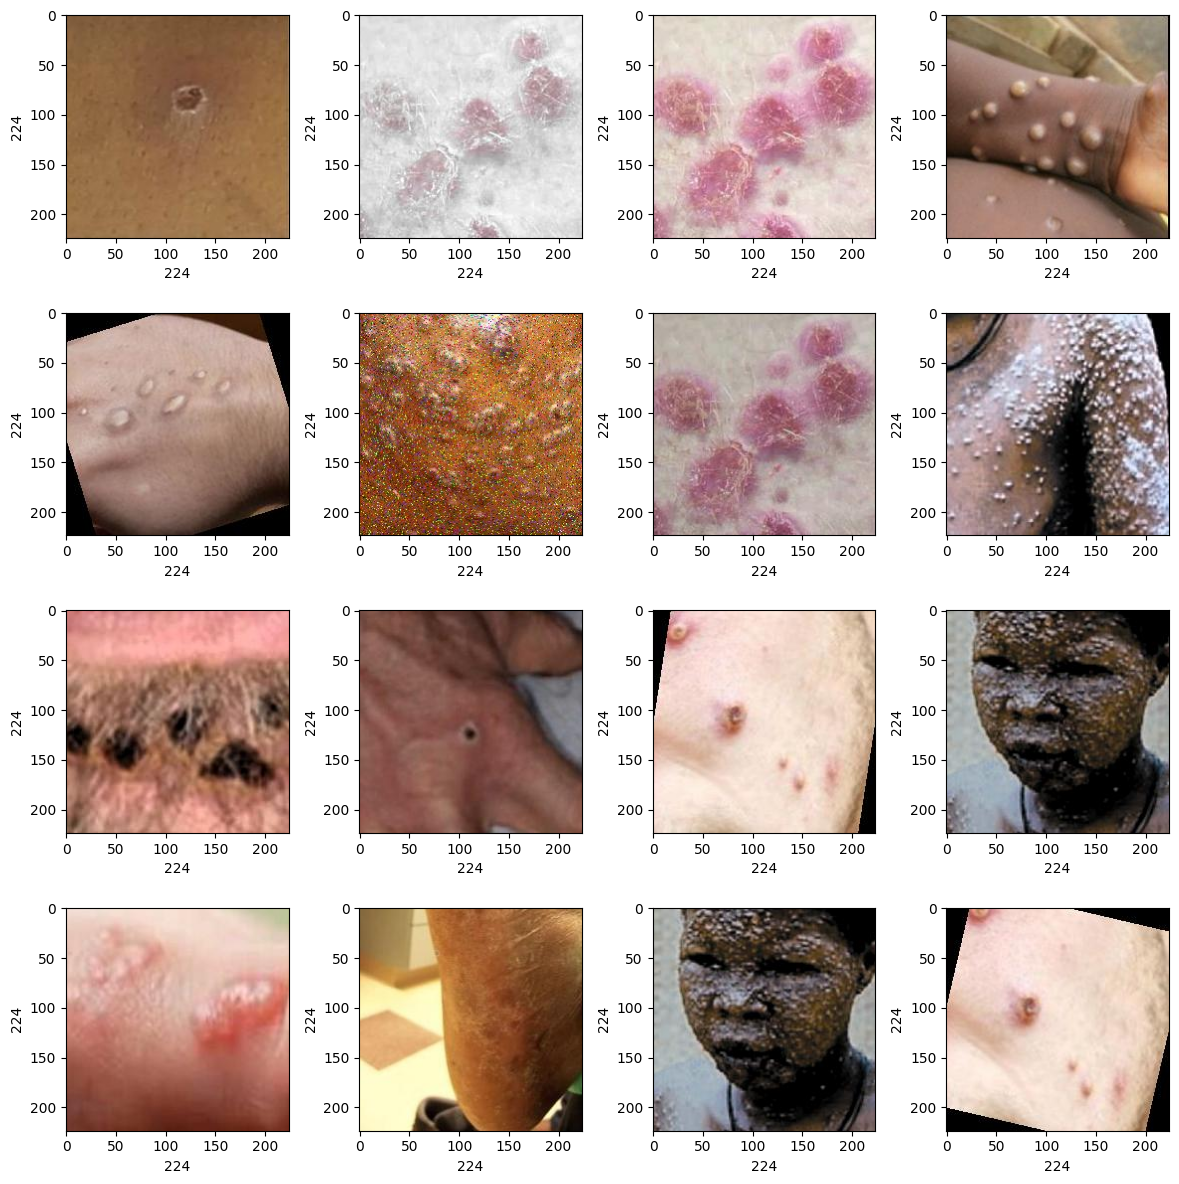

In [3]:
import os
import random
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Path to the dataset on the local machine
dataset_path = r"C:\Users\Shamiur Rahman\Desktop\Monkey Pox Dataset"

# List the contents of the dataset directory
print("Contents of the dataset directory:")
print(os.listdir(dataset_path))

# Plotting 12 images to check the dataset
plt.figure(figsize=(12, 12))
monkey_pox_path = os.path.join(dataset_path, "Monkey Pox")
for i in range(1, 17):
    plt.subplot(4, 4, i)
    plt.tight_layout()
    rand_img = imread(monkey_pox_path + '/' + random.choice(sorted(os.listdir(monkey_pox_path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize=10)  # width of image
    plt.ylabel(rand_img.shape[0], fontsize=10)  # height of image

plt.show()

In [5]:
#Converting Images to array
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, (256,256))
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [6]:
dir = r"C:\Users\Shamiur Rahman\Desktop\Monkey Pox Dataset"
# Get list of subdirectories, not files within the directory
root_dir = [d for d in listdir(dir) if os.path.isdir(os.path.join(dir, d))]
image_list, label_list = [], []
all_labels = ['Monkey Pox', 'Normal', 'Other']
binary_labels = [0,1,2]
temp = -1

# Reading and converting image to numpy array
for directory in root_dir:
  plant_image_list = listdir(f"{dir}/{directory}")
  temp += 1
  for files in plant_image_list:
    image_path = f"{dir}/{directory}/{files}"
    image_list.append(convert_image_to_array(image_path))
    label_list.append(binary_labels[temp])

In [9]:
# Visualize the number of classes count
label_counts = pd.DataFrame(label_list).value_counts()
label_counts.head()

0
2    2391
0     669
1     293
Name: count, dtype: int64

In [12]:
image_list[0].shape

(256, 256, 3)

In [14]:
label_list = np.array(label_list)
label_list.shape

(3353,)

In [16]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2, random_state=10)

# Preprocess the data
x_train = np.array(x_train, dtype=np.float32) / 255.0
x_test = np.array(x_test, dtype=np.float32) / 255.0
x_train = x_train.reshape(-1, 256, 256, 3)
x_test = x_test.reshape(-1, 256, 256, 3)

# Convert labels to categorical format
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Load pre-trained VGG16 model + higher level layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Data augmentation (optional)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(x_train)

# Train the model
epochs = 50
batch_size = 128
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_test, y_test),
                    epochs=epochs,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                               tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')])


Epoch 1/50


C:\AnnaConda\envs\myenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 384s 18s/step - accuracy: 0.5057 - loss: 1.0165 - val_accuracy: 0.7154 - val_loss: 0.8124
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 427s 20s/step - accuracy: 0.6684 - loss: 0.8756 - val_accuracy: 0.7154 - val_loss: 0.7930
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 342s 16s/step - accuracy: 0.6959 - loss: 0.8488 - val_accuracy: 0.7154 - val_loss: 0.7764
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 341s 16s/step - accuracy: 0.6816 - loss: 0.8457 - val_accuracy: 0.7154 - val_loss: 0.7621
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 377s 18s/step - accuracy: 0.6846 - loss: 0.8147 - val_accuracy: 0.7154 - val_loss: 0.7502
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 362s 17s/step - accuracy: 0.6874 - loss: 0.8153 - val_accuracy: 0.7154 - val_loss: 0.7398
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 341s 16s/step - accuracy: 0.6938 - loss: 0.7827 - val_accuracy: 0.7154 - val_loss: 0.7307
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 382s 18s/step - accuracy: 0.7012 - loss: 0.7916 - val_accuracy: 0.7154 - val_

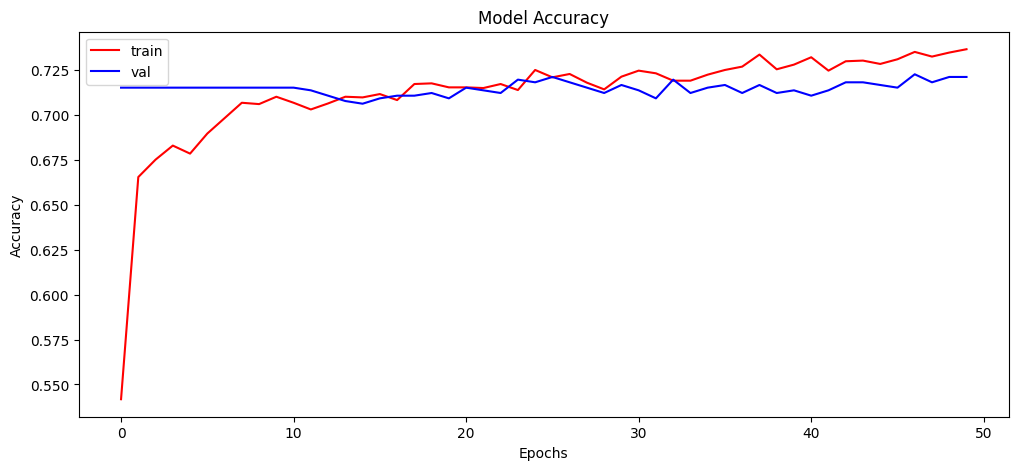

In [18]:
#Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

In [20]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
21/21 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.7450 - loss: 0.5611
Test Accuracy: 72.13114500045776


In [21]:
y_pred = model.predict(x_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step


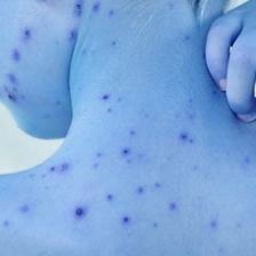

In [22]:
# Plotting image to compare
img = array_to_img(x_test[10])
img

In [23]:
# Finding max value from predition list and comaparing original value vs predicted
print("Originally : ",all_labels[np.argmax(y_test[10])])
print("Predicted : ",all_labels[np.argmax(y_pred[10])])

Originally :  Other
Predicted :  Other
